#### Aim: Trying to visualize the attention in a pretrained VAP model to see whether attention sinks occur here after some sample audios.

In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from vap.modules.lightning_module import VAPModule
from vap.data.datamodule import VAPDataModule
import os
import numpy as np

In [3]:
# Load the pre-trained model
checkpoint_path = "/home/serhan/Desktop/VoiceActivityProjection/example/checkpoints/checkpoint.ckpt"
model = VAPModule.load_from_checkpoint(checkpoint_path)
model.eval()

/home/serhan/miniconda3/envs/vap/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


VAPModule(
  (model): VAP(
    (encoder): EncoderCPC(
      (encoder): CPCModel(
        (gEncoder): CPCEncoder(
          (conv0): Conv1d(1, 256, kernel_size=(10,), stride=(5,), padding=(3,))
          (batchNorm0): ChannelNorm()
          (conv1): Conv1d(256, 256, kernel_size=(8,), stride=(4,), padding=(2,))
          (batchNorm1): ChannelNorm()
          (conv2): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
          (batchNorm2): ChannelNorm()
          (conv3): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
          (batchNorm3): ChannelNorm()
          (conv4): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
          (batchNorm4): ChannelNorm()
        )
        (gAR): CPCAR(
          (baseNet): LSTM(256, 256, batch_first=True)
        )
      )
      (downsample): Sequential(
        (0): Rearrange('b t d -> b d t')
        (1): CConv1d(
          256, 256, kernel_size=(5,), stride=(2,)
          (pad): ConstantPad1d(padding=(4, 0

In [4]:
# Prepare a batch of audio samples
audio_dir = "/home/erik/projects/data/Fisher/fisher_eng_tr_sp_d1/audio/000"
audio_files = [f"fe_03_{i:05d}.wav" for i in range(1, 100)]
batch_size = 4
sample_rate = 8000  # Assuming 8kHz sample rate, adjust if different

def load_and_process_audio(file_path):
    waveform, sr = torchaudio.load(file_path)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    # Assuming stereo audio, if mono, adjust accordingly
    if waveform.shape[0] == 1:
        waveform = waveform.repeat(2, 1)
    # Truncate or pad to 10 seconds
    target_length = 10 * sample_rate
    if waveform.shape[1] < target_length:
        waveform = torch.nn.functional.pad(waveform, (0, target_length - waveform.shape[1]))
    else:
        waveform = waveform[:, :target_length]
    return waveform

In [5]:
# Load a batch of audio samples
batch = []
for i in range(batch_size):
    file_path = os.path.join(audio_dir, audio_files[i])
    waveform = load_and_process_audio(file_path)
    batch.append(waveform)

batch = torch.stack(batch)

In [7]:
# Process the batch through the model
with torch.no_grad():
    outputs = model(batch)

In [12]:
# Function to extract attention weights
def get_attention_weights(module):
    attention_weights = []
    handles = []
    
    def hook(module, input, output):
        attention_weights.append(output[1].detach())
    
    for name, layer in module.named_modules():
        if isinstance(layer, torch.nn.MultiheadAttention):
            handle = layer.register_forward_hook(hook)
            handles.append(handle)
    
    return attention_weights, handles

In [18]:
# Extract attention weights
attention_weights, handles = get_attention_weights(model.model.transformer)

In [19]:
attention_weights

[]

In [14]:
# Run the model again to get attention weights
with torch.no_grad():
    _ = model(batch)

In [15]:
# Remove the hooks
for handle in handles:
    handle.remove()

In [16]:
# Visualize attention weights
num_layers = len(attention_weights)
fig, axes = plt.subplots(num_layers, 1, figsize=(10, 5 * num_layers))
if num_layers == 1:
    axes = [axes]

for layer, weights in enumerate(attention_weights):
    avg_weights = weights.mean(0).cpu().numpy()
    im = axes[layer].imshow(avg_weights, aspect='auto', cmap='viridis')
    axes[layer].set_title(f'Average Attention Weights - Layer {layer+1}')
    axes[layer].set_xlabel('Key Position')
    axes[layer].set_ylabel('Query Position')
    fig.colorbar(im, ax=axes[layer])

plt.tight_layout()
plt.savefig('attention_weights.png')
plt.close()

# Analyze attention to initial tokens
initial_token_attention = [weights[:, :, :4].mean(dim=(0, 1)).cpu().numpy() for weights in attention_weights]

fig, ax = plt.subplots(figsize=(10, 5))
for layer, attn in enumerate(initial_token_attention):
    ax.plot(range(4), attn, label=f'Layer {layer+1}')
ax.set_xlabel('Initial Token Position')
ax.set_ylabel('Average Attention Weight')
ax.set_title('Attention to Initial Tokens Across Layers')
ax.legend()
plt.savefig('initial_token_attention.png')
plt.close()

print("Analysis complete. Check 'attention_weights.png' and 'initial_token_attention.png' for visualizations.")

# Print statistics about attention to initial tokens
print("\nAverage attention to initial tokens:")
for layer, attn in enumerate(initial_token_attention):
    print(f"Layer {layer+1}: {attn.mean():.4f}")

print("\nAttention sink analysis:")
for layer, attn in enumerate(initial_token_attention):
    if attn[0] > attn[1:].mean() * 1.5:  # Arbitrary threshold, adjust as needed
        print(f"Layer {layer+1} shows strong attention sink behavior")
    else:
        print(f"Layer {layer+1} does not show strong attention sink behavior")

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1000x0 with 0 Axes>

#### 2nd Attempt

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import soundfile as sf
import numpy as np

from vap.modules.lightning_module import VAPModule
from vap.data.datamodule import VAPDataModule

In [3]:
# Set the paths
checkpoint_path = "/home/serhan/Desktop/StreamingVAP/example/checkpoints/checkpoint.ckpt"
audio_path = "/home/erik/projects/data/Fisher/fisher_eng_tr_sp_d1/audio/000/fe_03_00001.wav"

# Load the model
model = VAPModule.load_from_checkpoint(checkpoint_path)
model.eval()

/home/serhan/miniconda3/envs/vap/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


VAPModule(
  (model): VAP(
    (encoder): EncoderCPC(
      (encoder): CPCModel(
        (gEncoder): CPCEncoder(
          (conv0): Conv1d(1, 256, kernel_size=(10,), stride=(5,), padding=(3,))
          (batchNorm0): ChannelNorm()
          (conv1): Conv1d(256, 256, kernel_size=(8,), stride=(4,), padding=(2,))
          (batchNorm1): ChannelNorm()
          (conv2): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
          (batchNorm2): ChannelNorm()
          (conv3): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
          (batchNorm3): ChannelNorm()
          (conv4): Conv1d(256, 256, kernel_size=(4,), stride=(2,), padding=(1,))
          (batchNorm4): ChannelNorm()
        )
        (gAR): CPCAR(
          (baseNet): LSTM(256, 256, batch_first=True)
        )
      )
      (downsample): Sequential(
        (0): Rearrange('b t d -> b d t')
        (1): CConv1d(
          256, 256, kernel_size=(5,), stride=(2,)
          (pad): ConstantPad1d(padding=(4, 0

In [4]:
# Load and preprocess the audio
audio, sr = sf.read(audio_path)
if audio.ndim == 1:
    audio = np.stack([audio, audio])  # Duplicate mono to stereo
else:
    audio = audio.T  # Transpose if already stereo
audio = torch.from_numpy(audio).float()

In [5]:
# Ensure the audio is the correct shape (2, T)
if audio.shape[0] != 2:
    audio = audio.transpose(0, 1)

In [6]:
# Trim or pad the audio to 10 seconds (160000 samples at 16kHz)
target_length = 160000
if audio.shape[1] < target_length:
    audio = torch.nn.functional.pad(audio, (0, target_length - audio.shape[1]))
else:
    audio = audio[:, :target_length]

# Add batch dimension
audio = audio.unsqueeze(0)

In [8]:
# Get model outputs
with torch.no_grad():
    outputs = model(audio, attention=True)

In [9]:
# Extract attention weights
self_attn = outputs['self_attn']  # Shape: (B, 2, num_layers, num_heads, T, T)
cross_attn = outputs['cross_attn']  # Shape: (B, 2, num_layers, num_heads, T, T)

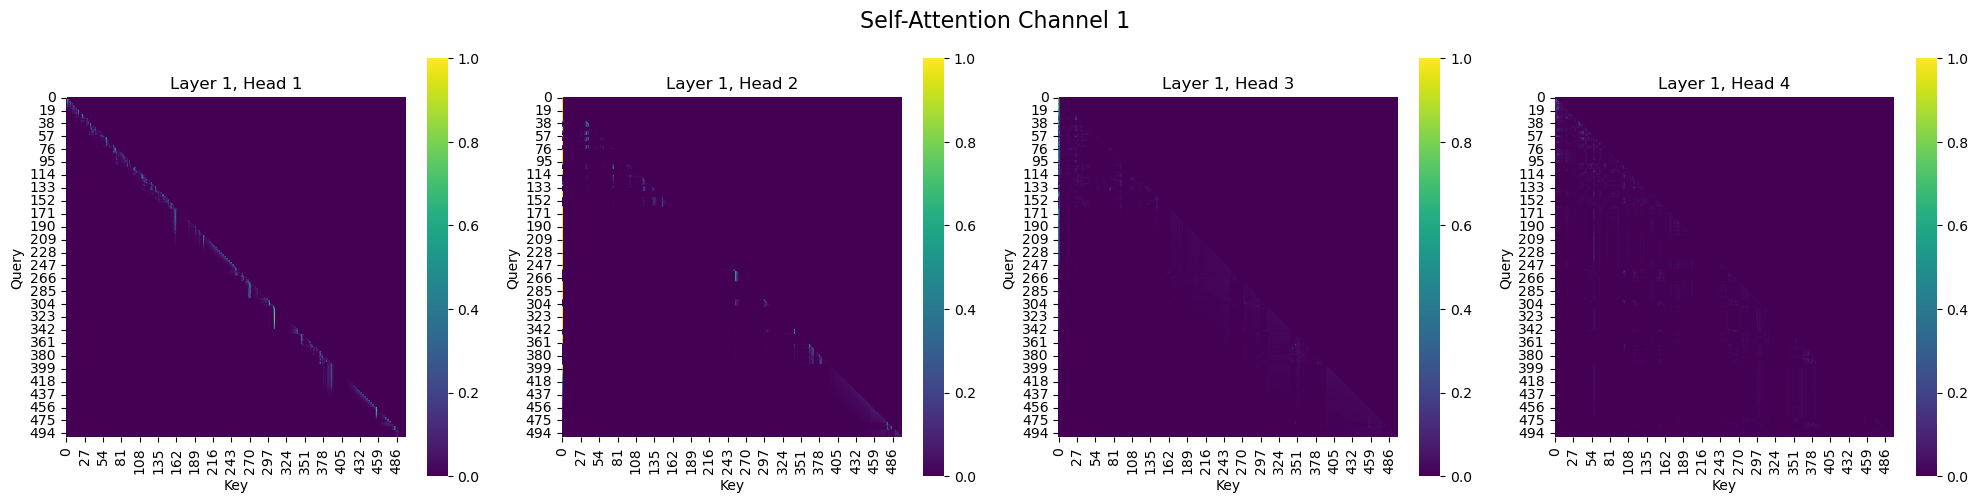

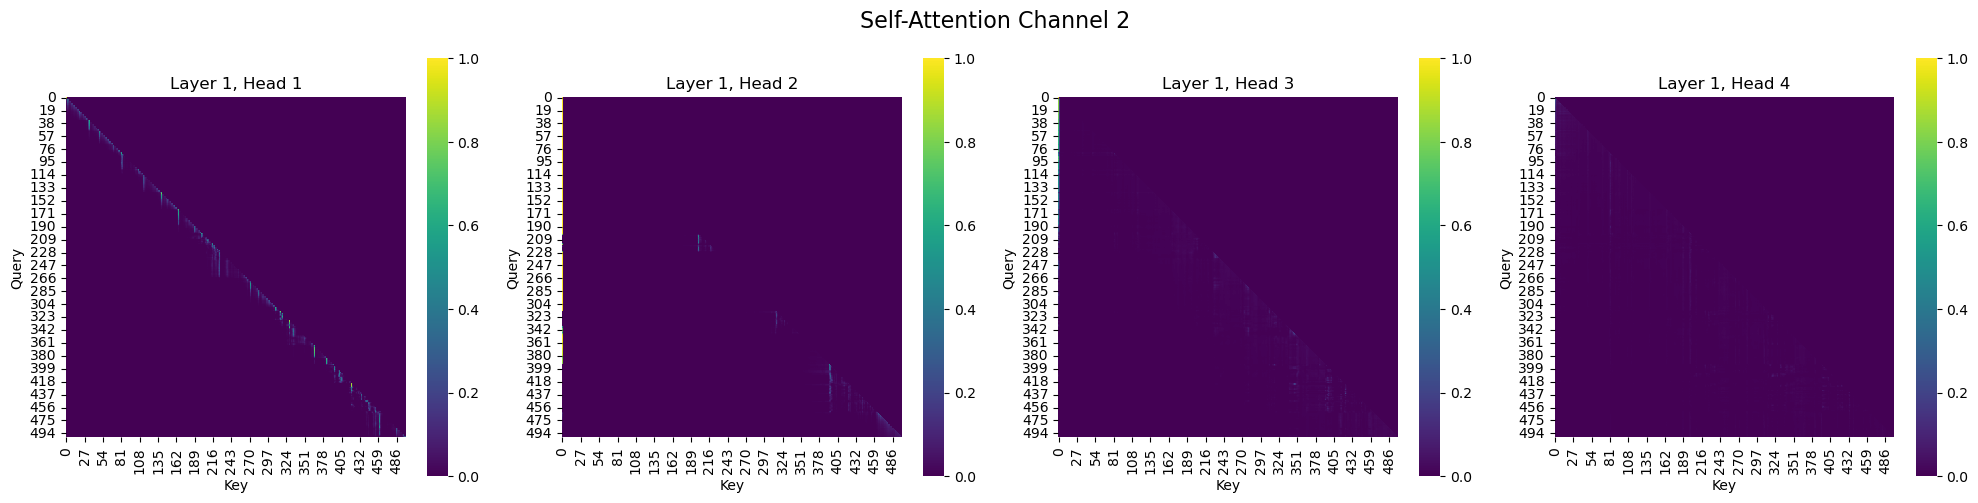

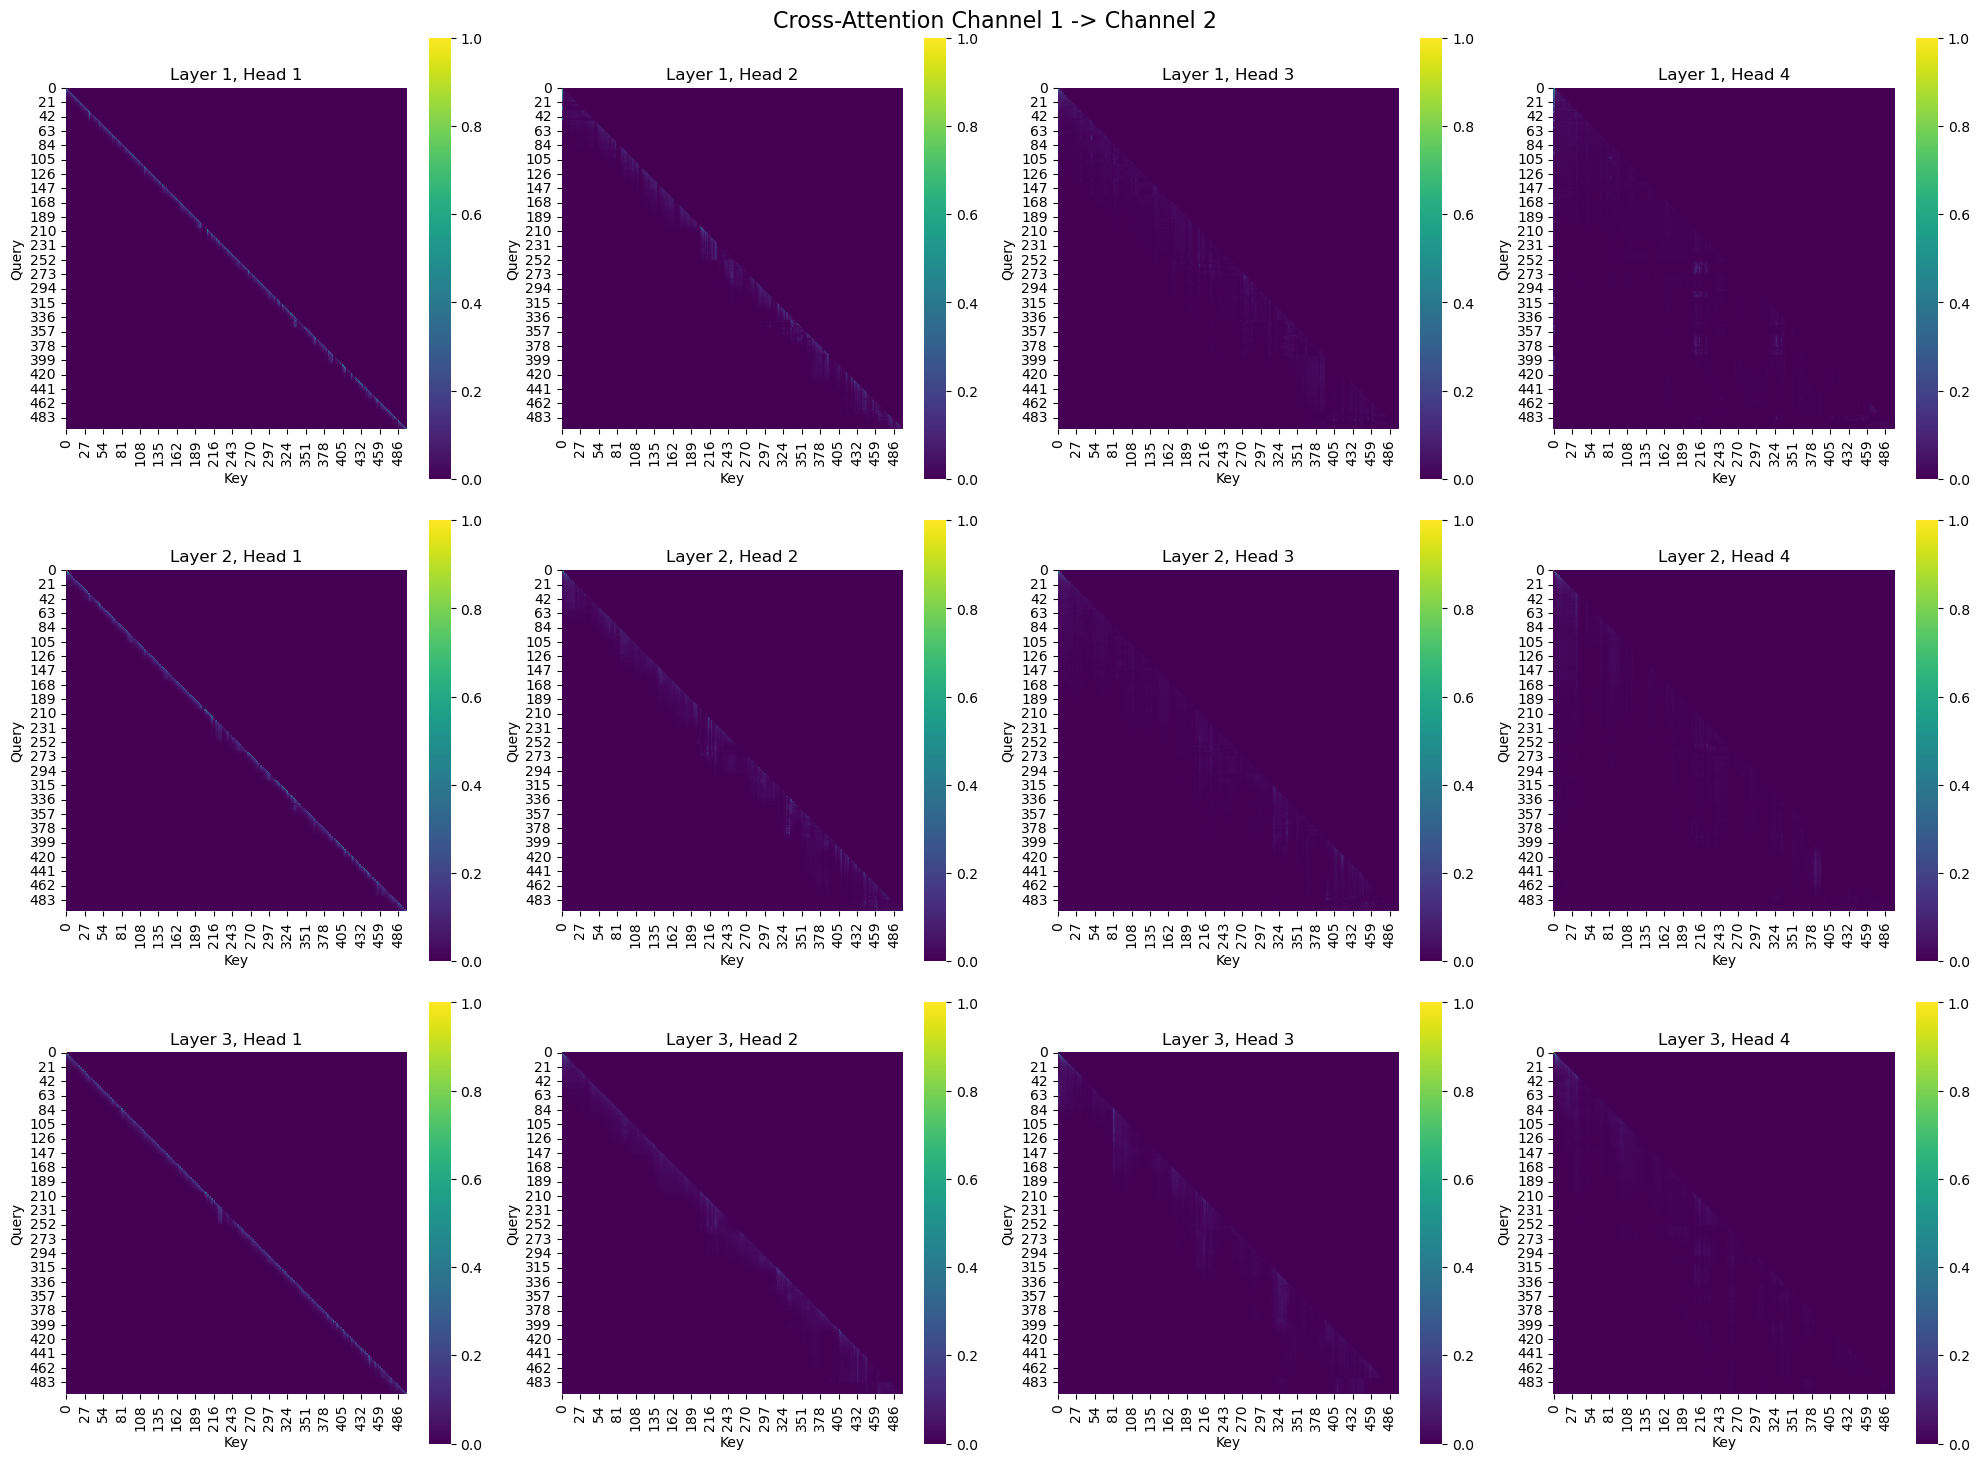

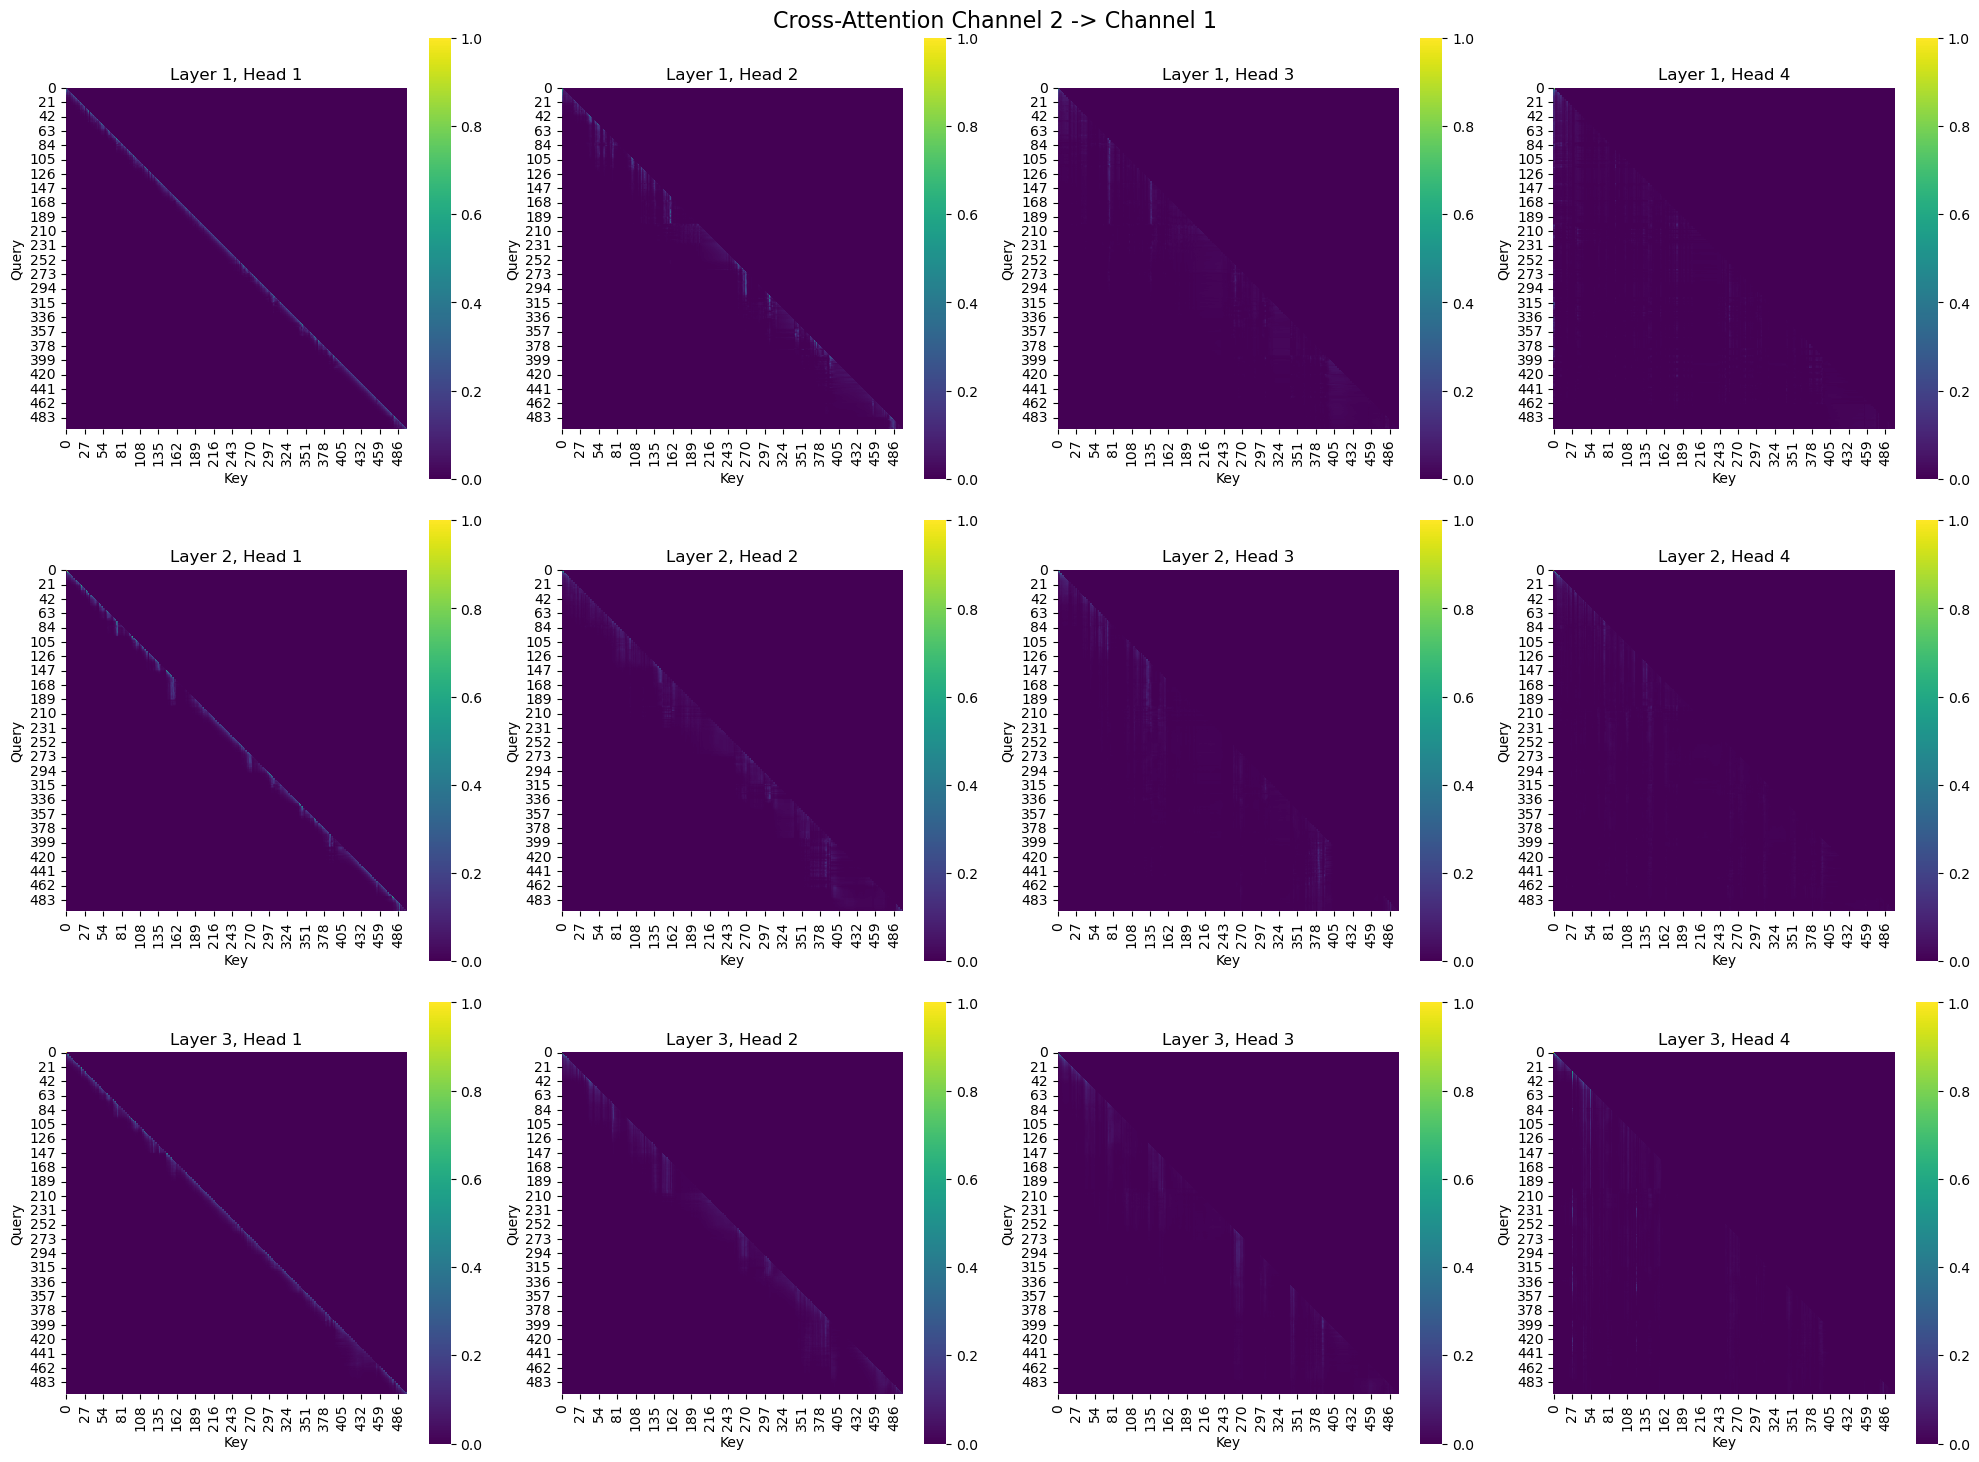

Self-Attention Channel 1:
Average attention to first token: 0.2154
Max attention to first token: 1.0000
First token is top-5 attended 74.20% of the time

Self-Attention Channel 2:
Average attention to first token: 0.2557
Max attention to first token: 1.0000
First token is top-5 attended 74.20% of the time


In [10]:
# Function to plot attention heatmaps
def plot_attention(attn, title):
    num_layers, num_heads, T, _ = attn.shape
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 5 * num_layers))
    fig.suptitle(title, fontsize=16)
    
    for layer in range(num_layers):
        for head in range(num_heads):
            ax = axes[layer, head] if num_layers > 1 else axes[head]
            sns.heatmap(attn[layer, head].cpu(), ax=ax, cmap='viridis', square=True)
            ax.set_title(f'Layer {layer+1}, Head {head+1}')
            ax.set_xlabel('Key')
            ax.set_ylabel('Query')
    
    plt.tight_layout()
    plt.show()

# Plot self-attention for both channels
plot_attention(self_attn[0, 0], 'Self-Attention Channel 1')
plot_attention(self_attn[0, 1], 'Self-Attention Channel 2')

# Plot cross-attention for both directions
plot_attention(cross_attn[0, 0], 'Cross-Attention Channel 1 -> Channel 2')
plot_attention(cross_attn[0, 1], 'Cross-Attention Channel 2 -> Channel 1')

# Analyze attention patterns
def analyze_attention_sinks(attn):
    avg_attn = attn.mean(dim=(0, 1))  # Average over layers and heads
    first_token_attn = avg_attn[:, 0]
    print(f"Average attention to first token: {first_token_attn.mean().item():.4f}")
    print(f"Max attention to first token: {first_token_attn.max().item():.4f}")
    print(f"First token is top-5 attended {(first_token_attn >= torch.topk(avg_attn, k=5, dim=1)[0][:, -1]).float().mean().item()*100:.2f}% of the time")

print("Self-Attention Channel 1:")
analyze_attention_sinks(self_attn[0, 0])
print("\nSelf-Attention Channel 2:")
analyze_attention_sinks(self_attn[0, 1])